<a href="https://colab.research.google.com/github/michalszczecinski/data-driven-notebooks/blob/master/engineering/industrial_automation_case_study_2e_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code Set Up

In [14]:
#@title Imports {display-mode: "form"}
import sys
import os
import platform
import random
import itertools
import math
import datetime

import numpy as np
import pandas as pd

# display
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import YouTubeVideo
from IPython.display import Image

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# reading google sheets files
import gspread
from oauth2client.client import GoogleCredentials

from collections import OrderedDict
from typing import List, Optional

# print versions
print (f"system: {sys.version}")
print (f"pandas: {pd.__version__}")
print (f"numpy: {np.__version__}")

system: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
pandas: 1.1.5
numpy: 1.19.5


In [2]:
# @title Dislay settings  {display-mode: "form"} 

# display all dataframes in cell
InteractiveShell.ast_node_interactivity = "all"

#pandas
pd.set_option("display.float_format", '{:.3f}'.format)
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", 200)

# plotting
sns.set(context='notebook', style="whitegrid", rc={"figure.figsize": (20, 10)})

In [3]:
# @title Helper functions {display-mode: "form"} 
def generate_header(author: Optional[str] = 'szczecinski',
                    title: Optional[str] = 'unknown',
                    description: Optional[str] = 'unknown',
                    prepared_for: Optional[str] = 'learning',
                    tags: Optional[List[str]] = [''],
                    links: Optional[List[str]] = ['']):
    """
    Generates standardised header with meta information describing the report.
    
    Args:
      author: Name of the author.
      title: Title of the report.
      description: Text describing the report.
      prepared_for: Text providing context and purpose of generating the report.
      tags: List of tags for searching.
      links: List of links for reference and cross linking.

    Returns:
      df_meta: Formatted Pandas Dataframe with meta information of the report.
    """
    meta_dict = OrderedDict()

    # Properties provided by author.
    meta_dict['author'] = author
    meta_dict['title'] = title
    meta_dict['description'] = description
    meta_dict['prepared_for'] = prepared_for
    meta_dict['tags'] = str(tags)
    meta_dict['links'] = str(links)

    # Properties auto generated by the system.
    runtime = datetime.datetime
    meta_dict['runtime'] = runtime.now().strftime("%Y-%m-%d %H:%M:%S")
    path = os.getcwd()
    meta_dict['path'] = path
    python_version = platform.python_version()
    meta_dict['python_version'] = python_version
    meta_dict['pandas_version'] = pd.__version__

    df_meta= pd.DataFrame(meta_dict, index=['report_information']).T
    return df_meta


def get_data_gsheet(name='data_jobs_summary'):
  """
  Load gsheet data into pandas dataframe.
  """
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  worksheet = gc.open(name).sheet1
  # get_all_values gives a list of rows.
  rows = worksheet.get_all_values()
  header = rows[0]
  df_data = pd.DataFrame.from_records(data=rows[1:], columns=header)
  return df_data

In [4]:
# @title Google Authentication {display-mode: "form"}
from google.colab import auth
auth.authenticate_user()

## Feeding and assembly mechanism.
[Link to this notebook](https://colab.research.google.com/drive/1KVnkVKQyv4hMg9MZ5__wdISe7QFFQGiY?usp=sharing)

In [5]:
# setting up header info
author = 'Michal Szczecinski'
prepared_for ='Mechatronics assignment'
title = 'Automated feeding and assembly mechanism.'
description = 'The mechanism is used for escaping cylindrical components to a work area and then insertng the components into assembly fixture.'
tags = ['#mechatronics', '#industrial-automation', '#feeder, #assembly, #fixture']
links = ['']
generate_header(author=author,
                title=title,
                description=description,
                prepared_for=prepared_for,
                tags=tags,
                links=links)

report_information
author                                                                                                                        Michal Szczecinski
title                                                                                                  Automated feeding and assembly mechanism.
description     The mechanism is used for escaping cylindrical components to a work area and then insertng the components into assembly fixture.
prepared_for                                                                                                             Mechatronics assignment
tags                                                                 ['#mechatronics', '#industrial-automation', '#feeder, #assembly, #fixture']
links                                                                                                                                       ['']
runtime                                                                                                                      2022-01-29 12:40:30
path                                                                                                                                    /content
python_version                                                                                                                            3.7.12
pandas_version                                                                                                                             1.1.5

In [13]:
#test image

from IPython.display import Image
Image('images/eng_ia_case_study_2_plc_diagram_1.png')


![](https://github.com/michalszczecinski/data-driven-notebooks/blob/c6c3e33f9f5fc7a68035b044a948ce9bf13b2909/images/eng_ia_case_study_2_plc_diagram_1.png)

## 1. Introduction

This project make use of Programmable Controller, Electro-pneumatic devices circuit to control multi actuators eg. One cylinder and one motor in an industrial automated machine. The control Chain theory consisting of the four elements provided an overview of the automated machine. Various types of electric and pneumatic components are incorporated to design and build this automated machine.
The hardwired circuits make use of discrete electro-mechanical components e.g. control relays, timers, counters to perform logical and sequential functions. Any change in machine operation would require re-wiring of the circuit of the hard-wired circuits. This can be costly and caused prolonged shutdown of production lines. It is also labour intensive to do the actual rewiring, troubleshooting and commissioning of the new circuit.
The programmable controllers make use  software solution to implement any new or change in the machine operation without having to re-configuring the hardwired circuit.

Source: Ngee Ann Industrial Information Sample report


### Problem statement

A company intends to automate the existing manual feeding mechanism in their Material Handling Line. The mechanism is used for escaping cylindrical components to a work area and then inserting the components into an assembly fixture.

### System description and sketch

* Figure 1A shows the schematic layout prepared by the Project Manager of the automated Material Feeding Station. The components are fed in an end-to-end condition, down a vertically mounted feed chute into the slider block. A pusher bar, driven by a pneumatic cylinder, then ejects the components into an assembly fixture.
* Figure 1B shows the dimension of the typical component to be handled.

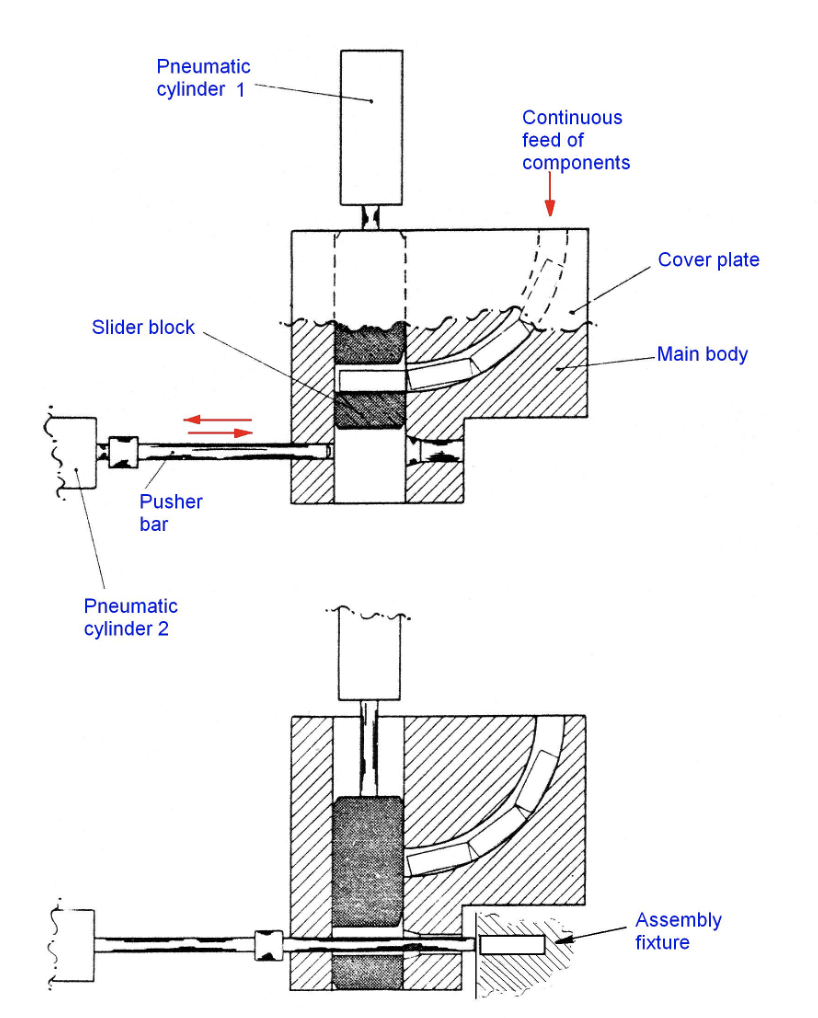

Figure 1A - Sketch of the feeder and assembly system.

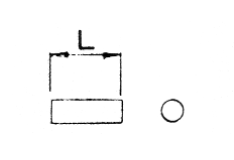

Figure 1B - Typical cylindrical component to be handled.

## Working Principles

1) What is the project all about?<br>
2) What do we hope to achieve?<br>
3) How does the system work?<br>

Our goal is to insert a cylindrical component into a fixture. For that we are going to use a feeder and assembly station consisting of **2 pneumatic cylinders**.

Cylinder 1 - to push the work piece down and place it in the appriopriate position. It is accomplished during the extending stroke.

Cylinder 2 - to push the workpiece to the right and insert it into the fixture. It is accomplished during the extending stroke.

Cylinder 1 has to act first, only after the work piece is in the correct positon then the Cylinder 2 can extend and insert the work piece into the fixture.

### Example of feeding station

Videos below illustrate use of cylinders for manipulating element inside the feeder station. It is a different system to the one we are discussing but it might be useful in terms of visualizing how parts of the systems could be implemented and work in practice.

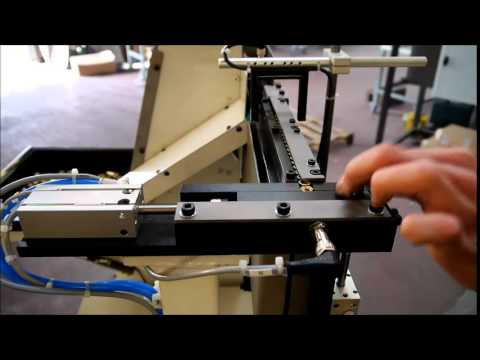

In [ ]:
YouTubeVideo('A_vZ1mKxJcQ', width=1024, height=576)

Segment Feeder<br>
Using segment/sword feeder to seperate and position screws in order to be fed for the joining operation.

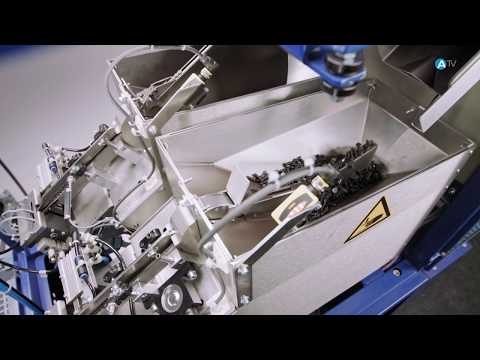

In [ ]:
YouTubeVideo('XXmJvQNFN40', width=1024, height=576)

Airway Automation

Feeding Cam Cap Bolts via airway

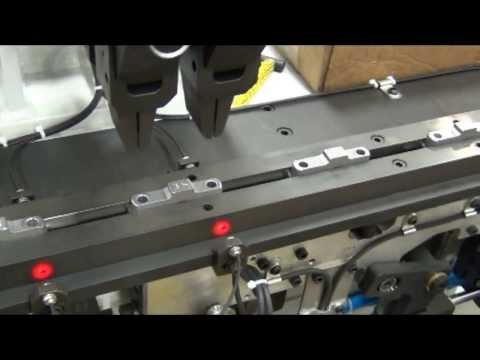

In [ ]:
YouTubeVideo('ISVDtYPNehg', width=1024, height=576)

## Theory

The Control Chain theory consisting of the four elements provided an overview of the automated machine. Various types of electric and pneumatic components are incorporated to design and build this automated machine.
  
Reduction of human involvement in controlling a machine or process using automation involves the following steps.

a) Replacement of human’s muscles (hands) by some output devices, e.g. the electrical motors, pneumatic actuators or hydraulic cylinders.

b) Replacement of human’s brain by a logic signal processing device such as a computer, micro-controller or programmable controller.
 
c) Replacement of human’s senses (eyes, ears, etc.) by input devices such as limit switches and sensors. 

d) The use of signal conversion means to match the output element with the signal-processing lay

### Feeders

A  feeder  is  an  extremely  important  element  in  a  bulk  material handling system, because it is the means by which the rate of solids flow from  a  hopper  or  bin  is  controlled.  When  a  feeder  stops,  solids  flow should  cease.  When  a  feeder  is  turned  on,  there  should  be  a  close correlation  between  its  speed  of  operation  and  the  rate  of  discharge  of the bulk solid. Feeders feed material to conveyors, processors, and other equipment  at  a  controlled  rate  to  maximize  efficiency  and  production.  In essence, they are short conveyors that come in multiple shapes and sizes. Feeders are also used in recycling applications.
Feeders  differ  from  conveyors  in  that  the  latter  are  only  capable  of transporting material, not modulating the rate of flow. Dischargers are not feeders. Such devices are sometimes used to encourage material to flow from a bin, but they cannot control the rate at which material flows. This requires a feeder.

TYPES OF FEEDERS
- Apron feeders
- Belt feeders
- Vibratory feeders
- Rotary feeders
- Reciprocating feeders
- Disc feeders
- Screw feeders
- Centrifugal feeders
- Flexible feeders

Source: A.K. Gupta, S.K. Arora, Jean Riescher Westcott - Industrial Automation and Robotics And Introduction-Mercury Learning & Information (2016)

## Design

- Hardware and Programmable Control ladder diagram.
- Analyse the motions, and dynamics (forces) involved in your system.
- Discuss the mechanics principles in the analysis.
- Support your analysis with equations wherever possible.
- Include calculations with correct data, if available to select the pneumatic cylinders size and stroke length.
- Motor selection.
- Equipment Brand and make of Pneumatic Cylinders and directional control valve. Compressed air supply pressure is 6 bar.

### Control Chain and equipment

| element                   | description                                                     |
|---------------------------|-----------------------------------------------------------------|
| Output Element            | 2x Pneumatic Double Acting Cylinder                                |
| Final Control Element     | 2x 5/2 way Double Solenoid Directional Control Valve |
| Signal Processing Element | PLC                      |
| Input Element             | AUTO_PB,  STOP_PB,  Reset_PB, Single_start_PB, Inductive Sensor            |

### Pneumatic drive circuit

I am going to use 2 double acting cylinders as I feel it gives me more flexibility and control over the system than single acting cylinders (which could also be used to implement the solution).

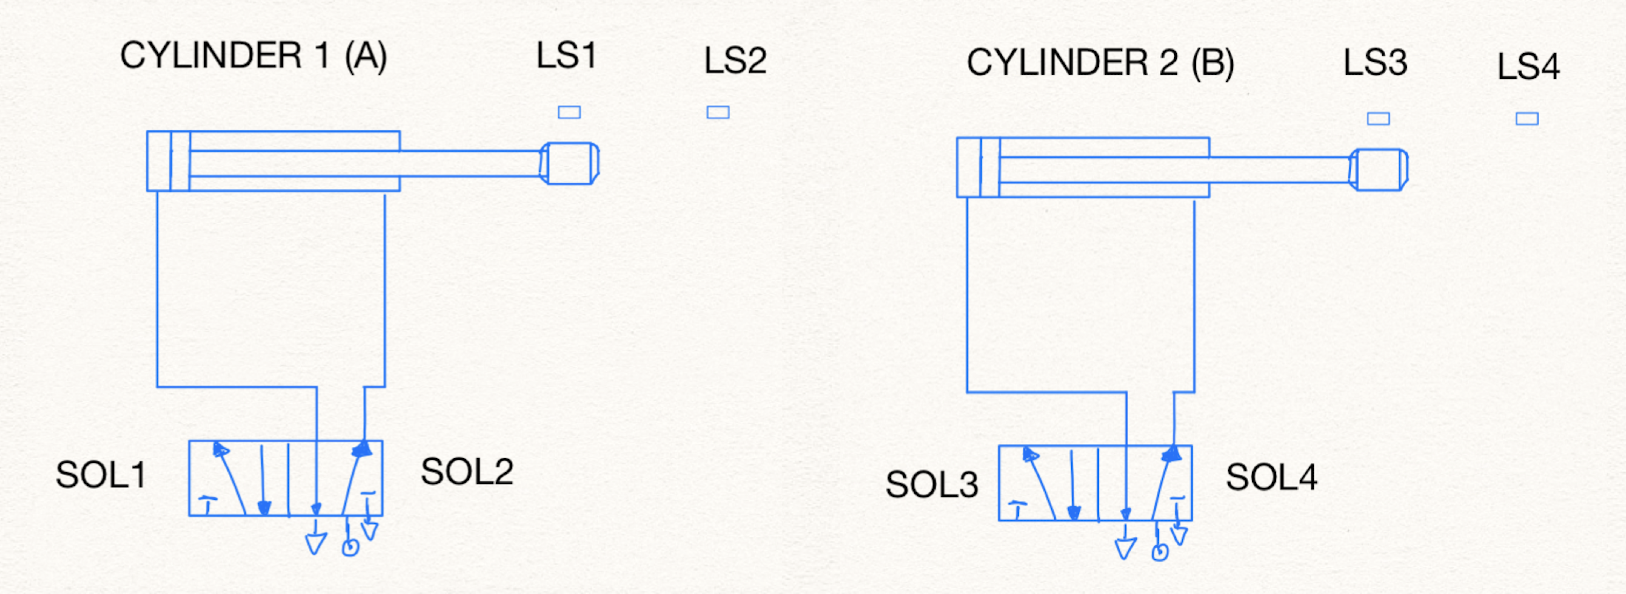

#### 5/2 way double solenoid valve

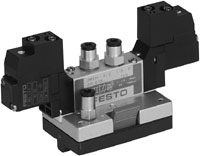

#### Double acting cylinder

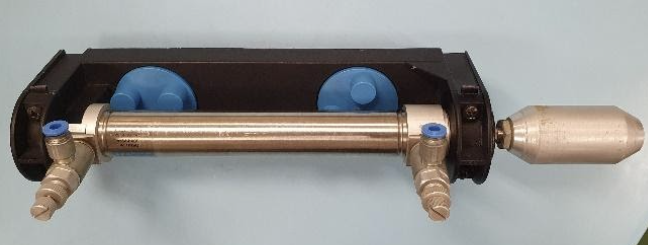

### Limit Switch

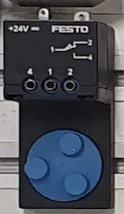

### Programmable Control solution equipment



#### Panasonic, FP sigma Programmable Controller

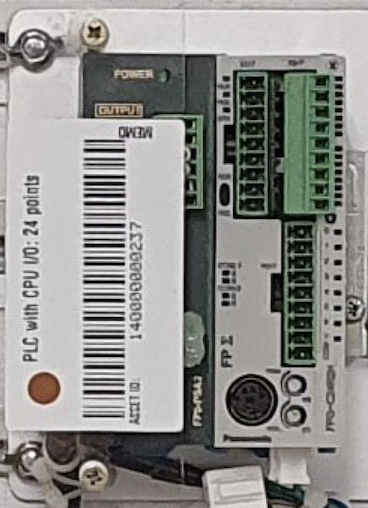

#### Control Elements 

When using a Programmable controller, only the input devices (switches and sensors) and the output devices (the solenoid of the directional control valve) need to be connected. The control relay and timer relay need NOT be physically connected. They are linked together by a program in the controller i.e. these control components have been replaced by a set of instructions which link each of these control items with the next in a manner to achieve the operating sequence required. 

### Push Button Switch

* COLD_PB
* AUTO_PB
* STOP_PB

### Electrical Control Ladder Diagram

### Sequence of operations

The sequence of operations is to be controlled by a programmable logic controller (PLC). The mechanism is to operate in the following manner:

1. A cold start pushbutton `COLD_PB` is pressed to prime the operation.
1. When an `AUTO_PB` is pressed, the station operates in continuous operation mode.
1. In the continuous-operation mode, `cylinder A` and `cylinder B` will perform the operating sequence according to the displacement-step diagram as shown on [figure 2]().
1. The continuous-cycle operation will stop at the end of cycle when a stop pushbutton `STOP_PB` is pressed.


### Displacement-Step Diagram


The solution is going to have following continous sequence: A+ B+ A- B-.Cylinder A extends first to position and orientate the workpiece, then Cylinder B extends to insert it into the fixture. Then cylinder B retracts and Cylinder A retract back to the fully retracted position. 

I think we could optimise time needed to perform action by coordinating cylinders A and B in a way that cylinder A would retract while cylinder B is extending but the solution we suggested is simpler and has a desired property of being able to better control the position of the workpiece.

### Abbreviated Notation of Motion (Motion Sequence)

The sequence of motion of extension and retraction of cylinder A are indicated by A + or A - respectively. The "+" sign after the abbreviated "A" means advance or extension of piston of cylinder A.  The "-" sign represents retraction of piston of the cylinder A.

Abbreviated notation contains the following information in one operating cycle:
- the required actions such as cylinder movements
- the  necessary  conditions  such  as  limit  switch  signals  to  trigger  the  respective sequence step during machine cycle.




The abreviated notation representation of the motion sequence of our suggested solution is as follows:

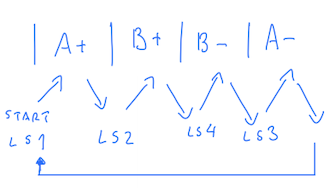

### Shift Register Technique

The Shift Register Technique works on a “passing token concept” as illustrated in Figure 4. When the token is in a certain group, the group is said to be active and  the  necessary action related to the group will be carried out. The group will remain active until the respective limit switch condition is achieved and this signifies the completion of the current group. The token will then pass on to the next group to execute the next group.

Source: Ngee Ann Polytechnic, Industrial Information, Chapter PLC3

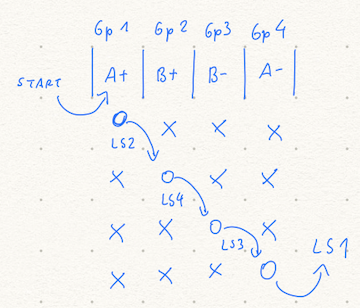

### I/O & IR Assignment

In [ ]:
get_data_gsheet('ia_case_study2')

Class Identifier (tag names) FP Address  Type
0   VAR_GLOBAL                AUTO_PB          X0     
1   VAR_GLOBAL                    LS1          X1     
2   VAR_GLOBAL                    LS2          X2     
3   VAR_GLOBAL                    LS3          X3     
4   VAR_GLOBAL                    LS4          X4     
5   VAR_GLOBAL                COLD_PB          X5     
6   VAR_GLOBAL                STOP_PB          X6     
7   VAR_GLOBAL                   SOL1          Y0     
8   VAR_GLOBAL                   SOL2          Y1     
9   VAR_GLOBAL                   SOL3          Y2     
10  VAR_GLOBAL                   SOL4          Y3

### I/O Physical connection

Wiring diagram at the input /output modules of the controller.


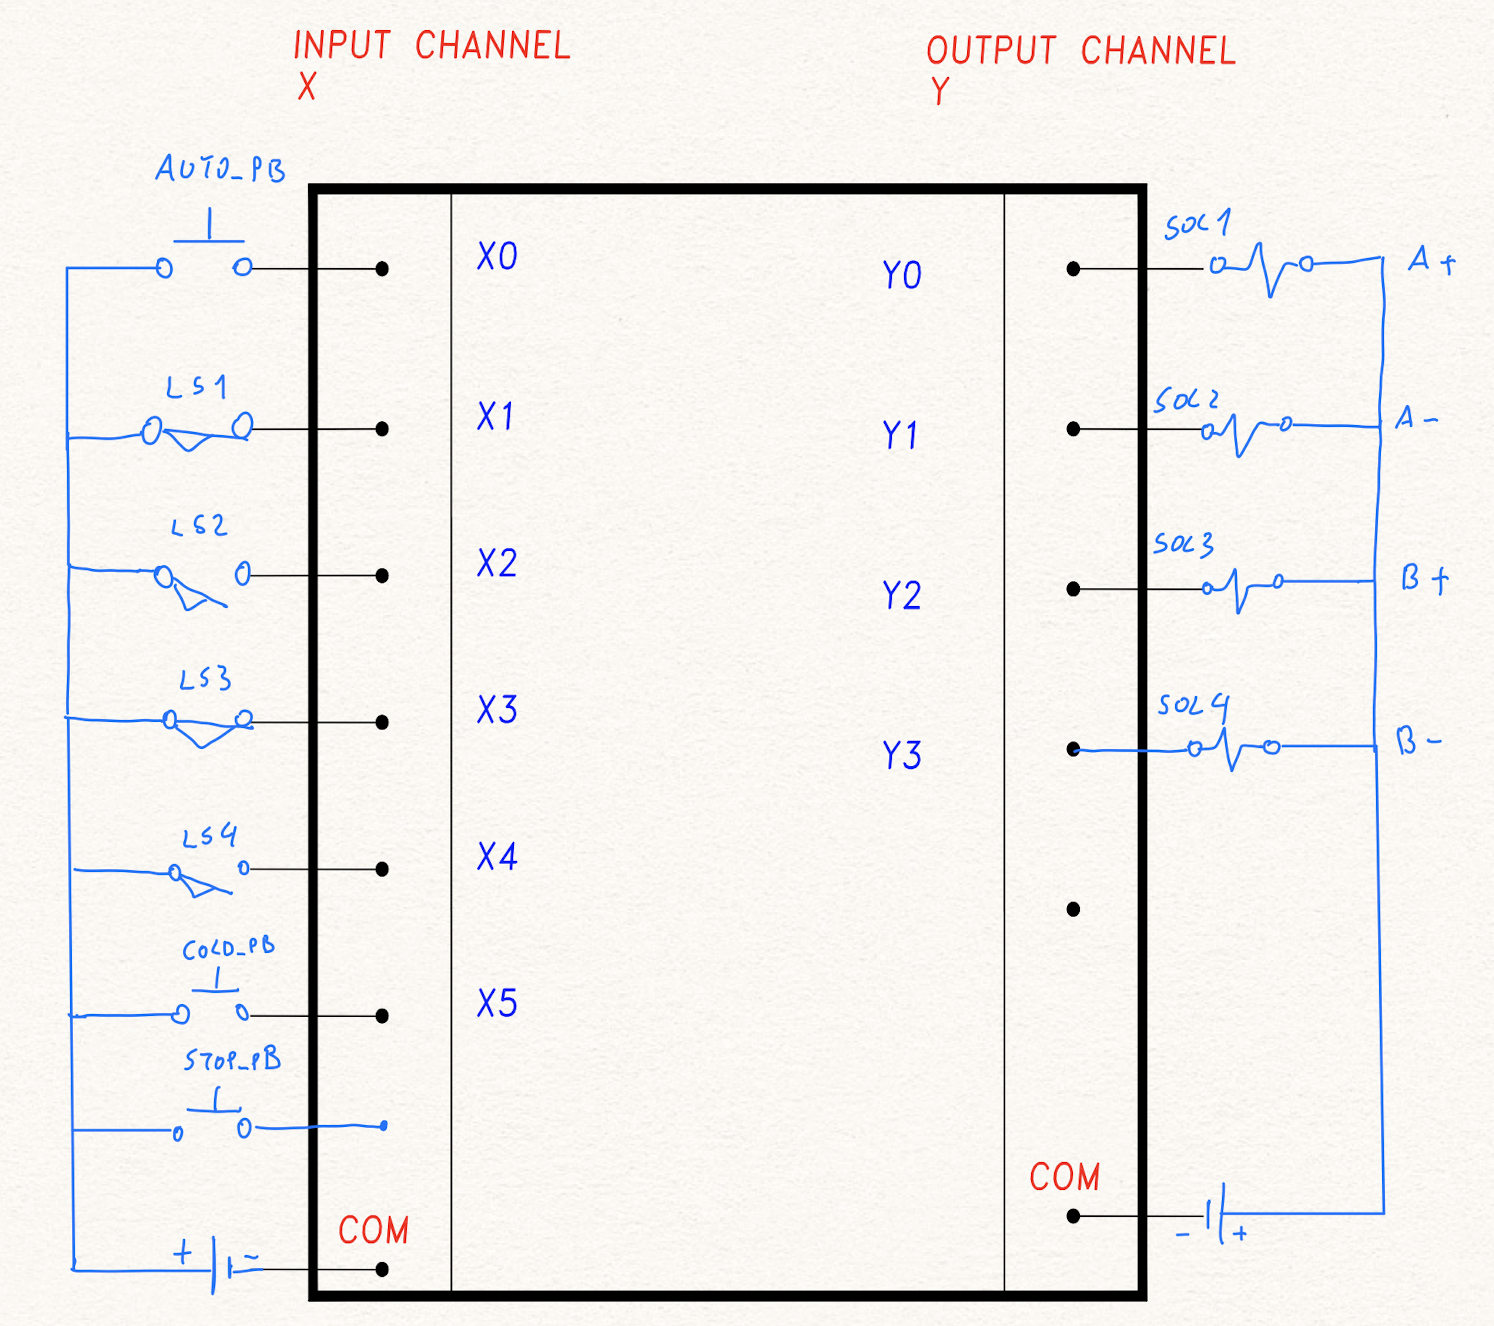

### Programmable Controller Ladder Diagram

Hand Design

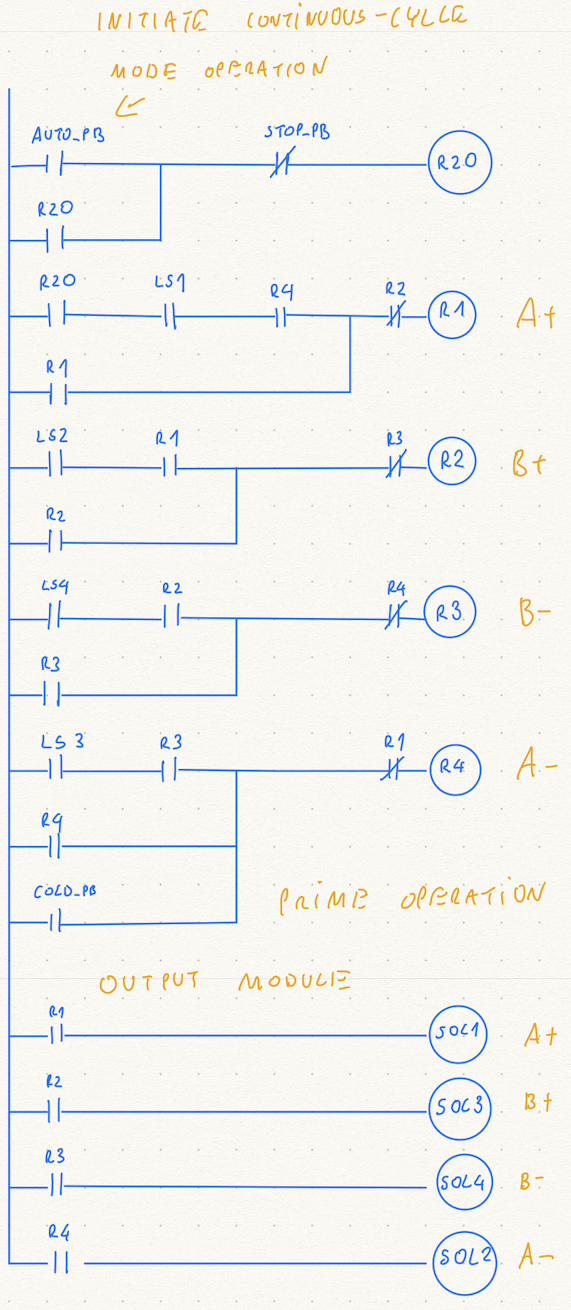

In [15]:
Image('https://raw.githubusercontent.com/michalszczecinski/data-driven-notebooks/c6c3e33f9f5fc7a68035b044a948ce9bf13b2909/images/eng_ia_case_study_2_plc_diagram_1.png')

[PLC fiddle design](https://www.plcfiddle.com:/fiddles/c3b9f916-10fb-4846-b3fd-df87651ad28a)

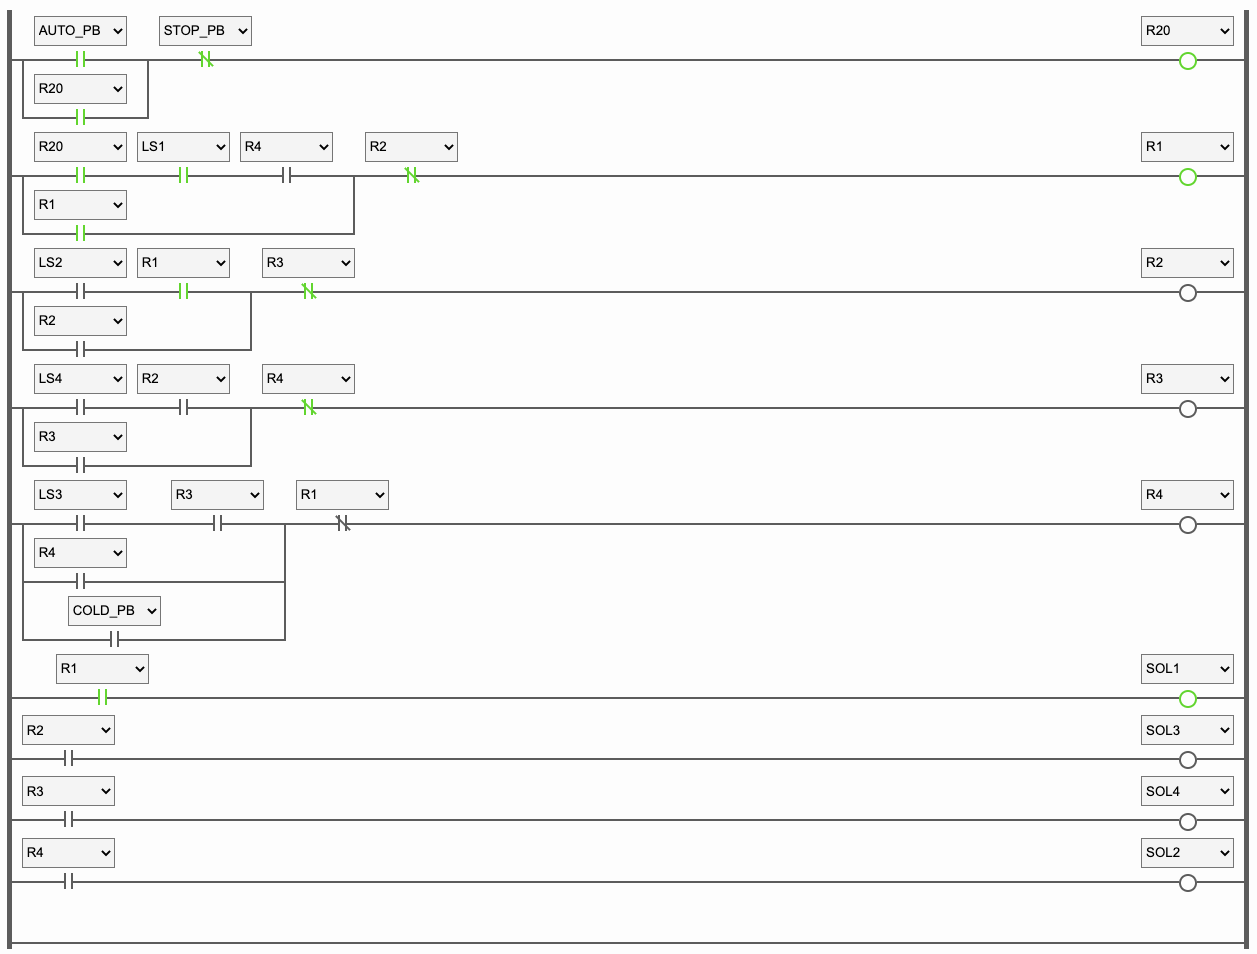

In [16]:
Image('https://raw.githubusercontent.com/michalszczecinski/data-driven-notebooks/c6c3e33f9f5fc7a68035b044a948ce9bf13b2909/images/eng_ia_case_study_2_plc_diagram_fiddle.png')

In [24]:
# list of parts for final specification
push_buttons = ['AUTO_PB','STOP_PB','COLD_PB']
coils =['R20','R1','R2','R3','R4']
limit_switches = ['LS1', 'LS2','LS3','LS4']
solenoids = ['SOL1','SOL2','SOL3','SOL4']

### Selection of Cylinders

Selection of a suitable cylinder for a particular application will be based on:

* Load to be moved 
* Stroke length required

#### Selection procedures

1. Select a cylinder and a valve for a particular application.
1. Determine whether cylinder is single or double-acting, rodless or other types.
1. Determine the output force, bore diameter and rod diameter of pneumatic cylinder.
1. Calculate air consumption
1. Determine the operating power requirements for a pneumatic system.
1. Select stroke length from supplier's catalogue.
1. Select rod diameter from the buckling chart.
1. Select Type of Mounting
1. Consider other aspects:     
* Prevent piston from turning?
* angles
* friction
* Add speed requirements into the equation
* Withstand bending loads?
* Size & type of connection.
* Special requirements, e.g contactless sensing, position, cushioning, etc.

### Forces in Cylinders

\begin{align}
F_l &= A * P - F_f \tag{1} \\
A &= \frac{\pi * D^2}{4} \tag{2} \\
\end{align}

where<br>
A = bore area   
D = bore diameter   
Fl = load     
Ff = friction force

\begin{align}
F_l &= A * P - F_f  \\ 
F_l + F_f &= A * P  \\ 
F_l + F_f &= \frac{\pi * D^2}{4} * P \tag{from 2} \\ 
\frac{F_l + F_f}{P} &= \frac{\pi * D^2}{4} \\ 
\frac{F_l + F_f}{P} * \frac{4}{\pi} &= D^2 \\ 
\frac{(F_l + F_f)*4}{P*\pi} &= D^2 \\ 
D &= \sqrt{\frac{(F_l + F_f)*4}{P*\pi}} \\ 
\end{align}

#### Assumptions

Load acting on the cylinder = 50 N.

Workpiece movement = 100 mm.     

Compressed air Pressure = 6 bar. 


In [17]:
# workpiece movement in m 
workpiece_movement = 0.100
# pressure in pascal (N/m^2)
P = 6 * 10**5
# load acting on cylinder in N
Fl = 50
# friction force in N
Ff = 0

In [18]:
# diameter in meters (m)
D = math.sqrt(
    (Fl+Ff)*4/(P * math.pi)
              )
print(f'Bore Diameter: {D*10**3} mm')

Bore Diameter: 10.300645387285055 mm


In [19]:
# selecting cylinder type based on buckling chart
# example DN-400-20

stroke_length = 0.100
d = 0.004
cylinder_type = f'DN-{round(stroke_length*10**3)}-{round(d*10**3)}'
print (f'cylinder_type: {cylinder_type}')

cylinder_type: DN-100-4


### Select cylinder mounting type

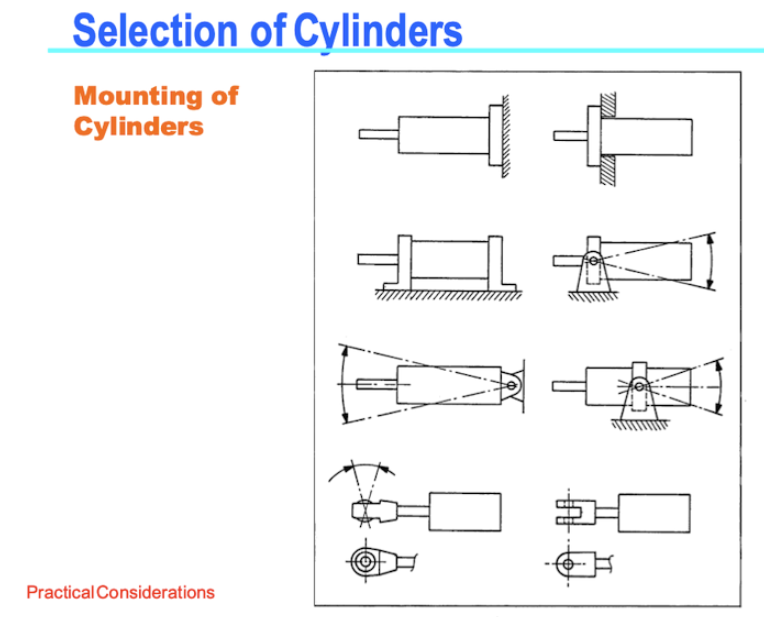

In [22]:
url = 'https://raw.githubusercontent.com/michalszczecinski/data-driven-notebooks/e8cea215d8c035dd2955718862ba125544881364/images/eng_ia_case_study2_cylinder_selection.png'
Image(url)

In [26]:
# mounting type
mounting_type = 'front-flange mounting'

### Final specification table

In [27]:
data_spec = {
    'push buttons': str(push_buttons),
    'coils': str(coils),
    'limit switches': str(limit_switches),
    'stroke_length': stroke_length,
    'cylinder_type': cylinder_type,
    'mounting_type': mounting_type,
             }

In [28]:
pd.DataFrame(data=data_spec, index=['value']).T

value
push buttons    ['AUTO_PB', 'STOP_PB', 'COLD_PB']
coils             ['R20', 'R1', 'R2', 'R3', 'R4']
limit switches       ['LS1', 'LS2', 'LS3', 'LS4']
stroke_length                               0.100
cylinder_type                            DN-100-4
mounting_type               front-flange mounting

## Discussion

I think we could consider alternative solutions with the goal of optimising speed of completing jobs. This would depend on the requiremnts and conditions in the factory, but one idea is that we could have cylinder B and A retracting at the same time, saving some time. This could potentially sacrifice the stability of the workpiece but would enable us to complete more cycles in a given time.


The primary purpose of this case study is about design of PLC program, which has been done. The part however that is additional and would require more experience is about selection of pneumatic drive elements. Ideally we would build prototype of this kind of system to get a better feel for selecting right cylinder sizes and parameters of the equipment.

## Conclusion

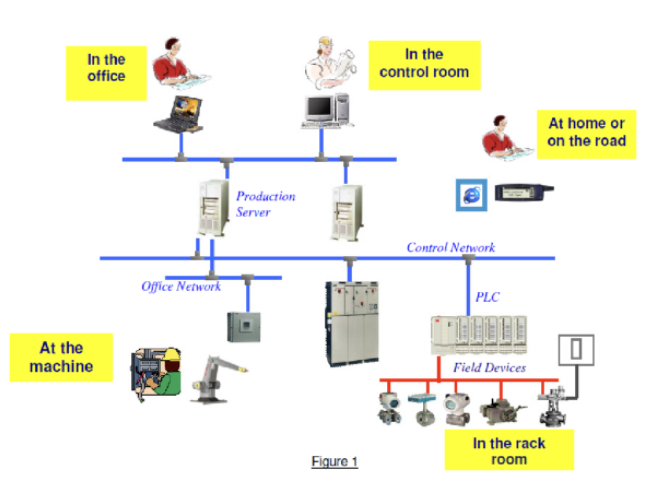

In the exercise above we have:
1. Presented scenario we would like to automate - system for feeding cylindrical parts and ejecting them into assembly fixture.
1. Described equipment and theory underlying our system - feeder types, pneumatic drive elements etc.
1. Described control chain and designed PLC program diagram.
1. Presented mechanics principles and calculated the parameters needed for the selection of actuating cylinder.
1. Discussed improvements and extension to the system - including optimised synchronisation of cylinders


## References

[1] Industrial Automation and Robotics, A.K. Gupta, S.K. Arora, J.R Westcott <br>
[2] Ngee Ann Polytechnic; INDUSTRIAL AUTOMATION; CHAPTER EP3, Input & Signal Processing Elements, The Electro-Mechanical Components <br>
[3] Ngee Ann Polytechnic; INDUSTRIAL AUTOMATION; CHAPTER EP7, Practical Considerations of Pneumatic System Implementations <br>
[4] Source: Ngee Ann Polytechnic, Industrial Information, Chapter PLC3 <br>



In [ ]:
# @title Converting and exporting output {display-mode: "form"} 

# mount drive to access .ipynb file
from google.colab import drive
drive.mount('/content/drive')

# covert and export output 
!cp 'drive/My Drive/Colab Notebooks/industrial_automation_case_study_2e_v0.1.ipynb' ./
!jupyter nbconvert --to HTML "industrial_automation_case_study_2e_v0.1.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook industrial_automation_case_study_1e_v1.0.ipynb to HTML
[NbConvertApp] Writing 4767306 bytes to industrial_automation_case_study_1e_v1.0.html
